In [1]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)

In [2]:
df = pd.read_csv("../data/post-operative-data.csv")
df.head()

,L-CORE,L-SURF,L-O2,L-BP,SURF-STBL,CORE-STBL,BP-STBL,COMFORT,decision ADM-DECS
0,mid,low,excellent,mid,stable,stable,stable,15,A
1,mid,high,excellent,high,stable,stable,stable,10,S
2,high,low,excellent,high,stable,stable,mod-stable,10,A
3,mid,low,good,high,stable,unstable,mod-stable,15,A
4,mid,mid,excellent,high,stable,stable,stable,10,A


In [3]:
df.shape

(90, 9)

In [4]:
df.columns

Index(['L-CORE', 'L-SURF', 'L-O2', 'L-BP', 'SURF-STBL', 'CORE-STBL', 'BP-STBL',
       'COMFORT', 'decision ADM-DECS'],
      dtype='str')

In [5]:
list(df.columns)

['L-CORE',
 'L-SURF',
 'L-O2',
 'L-BP',
 'SURF-STBL',
 'CORE-STBL',
 'BP-STBL',
 'COMFORT',
 'decision ADM-DECS']

In [6]:
for col in df.columns:
    print(col, "->", sorted(df[col].unique()))

L-CORE -> ['high', 'low', 'mid']
L-SURF -> ['high', 'low', 'mid']
L-O2 -> ['excellent', 'good']
L-BP -> ['high', 'low', 'mid']
SURF-STBL -> ['stable', 'unstable']
CORE-STBL -> ['mod-stable', 'stable', 'unstable']
BP-STBL -> ['mod-stable', 'stable', 'unstable']
COMFORT -> ['10', '15', '5', '7', '?']
decision ADM-DECS -> ['A', 'A ', 'I', 'S']


In [7]:
df['decision ADM-DECS'] = df['decision ADM-DECS'].str.strip()

In [8]:
df = df[df['decision ADM-DECS'].isin(['A', 'S'])]

In [9]:
df['decision ADM-DECS'].value_counts()

decision ADM-DECS
A    64
S    24
Name: count, dtype: int64

In [10]:
df = df.rename(columns={"decision ADM-DECS": "decision"})

In [11]:
df.columns

Index(['L-CORE', 'L-SURF', 'L-O2', 'L-BP', 'SURF-STBL', 'CORE-STBL', 'BP-STBL',
       'COMFORT', 'decision'],
      dtype='str')

In [12]:
df.columns = (
    df.columns
    .str.lower()
    .str.replace("-", "_")
    .str.strip()
)

In [13]:
df['comfort'] = df['comfort'].replace('?', np.nan)
df['comfort'] = df['comfort'].astype(float)
df['comfort'] = df['comfort'].fillna(df['comfort'].median())

In [14]:
for col in df.columns:
    print(col, "->", sorted(df[col].unique()))

l_core -> ['high', 'low', 'mid']
l_surf -> ['high', 'low', 'mid']
l_o2 -> ['excellent', 'good']
l_bp -> ['high', 'low', 'mid']
surf_stbl -> ['stable', 'unstable']
core_stbl -> ['mod-stable', 'stable', 'unstable']
bp_stbl -> ['mod-stable', 'stable', 'unstable']
comfort -> [np.float64(5.0), np.float64(7.0), np.float64(10.0), np.float64(15.0)]
decision -> ['A', 'S']


In [15]:
df['decision'] = df['decision'].map({
    'A': 1,  #risky
    'S': 0   #risk-free
})

In [16]:
df['decision'].value_counts()

decision
1    64
0    24
Name: count, dtype: int64

In [17]:
nan_rows = df[df.isna().any(axis=1)]
print(nan_rows)


Empty DataFrame
Columns: [l_core, l_surf, l_o2, l_bp, surf_stbl, core_stbl, bp_stbl, comfort, decision]
Index: []


In [18]:
nan_columns = df.loc[:, df.isna().any()]
print(nan_columns)


Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89]

[88 rows x 0 columns]


In [19]:
level_map = {"mid": 0, "low": 1, "high":1}
for col in ["l_core", "l_surf", "l_bp"]:
    df[col] = df[col].map(level_map)

In [20]:
o2_map = {"excellent": 0, "good": 1}
df["l_o2"] = df["l_o2"].map(o2_map)

In [21]:
stability_map = {"stable": 0, "mod_stable": 1, "unstable": 2}
for col in ["core_stbl", "surf_stbl", "bp_stbl"]:
    df[col] = df[col].map(stability_map)

In [22]:
X = df.drop("decision", axis=1)
y = df["decision"]

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.value_counts(), "y_test:", y_test.value_counts())


X_train: (70, 8) X_test: (18, 8)
y_train: decision
1    51
0    19
Name: count, dtype: int64 y_test: decision
1    13
0     5
Name: count, dtype: int64


In [24]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    max_depth=3,
    min_samples_leaf=5,
    random_state=42
)

dt.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",3
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current no

In [25]:
from sklearn.metrics import classification_report
import pandas as pd 

y_pred = dt.predict(X_test)

print(classification_report(y_test, y_pred))

importance = pd.Series(dt.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature importance:\n", importance)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.72      1.00      0.84        13

    accuracy                           0.72        18
   macro avg       0.36      0.50      0.42        18
weighted avg       0.52      0.72      0.61        18

Feature importance:
 l_surf       0.382304
bp_stbl      0.287518
l_core       0.212619
l_bp         0.065883
l_o2         0.033006
surf_stbl    0.018670
core_stbl    0.000000
comfort      0.000000
dtype: float64


/Users/busra/postoperative-risk-prediction/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/busra/postoperative-risk-prediction/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/busra/postoperative-risk-prediction/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

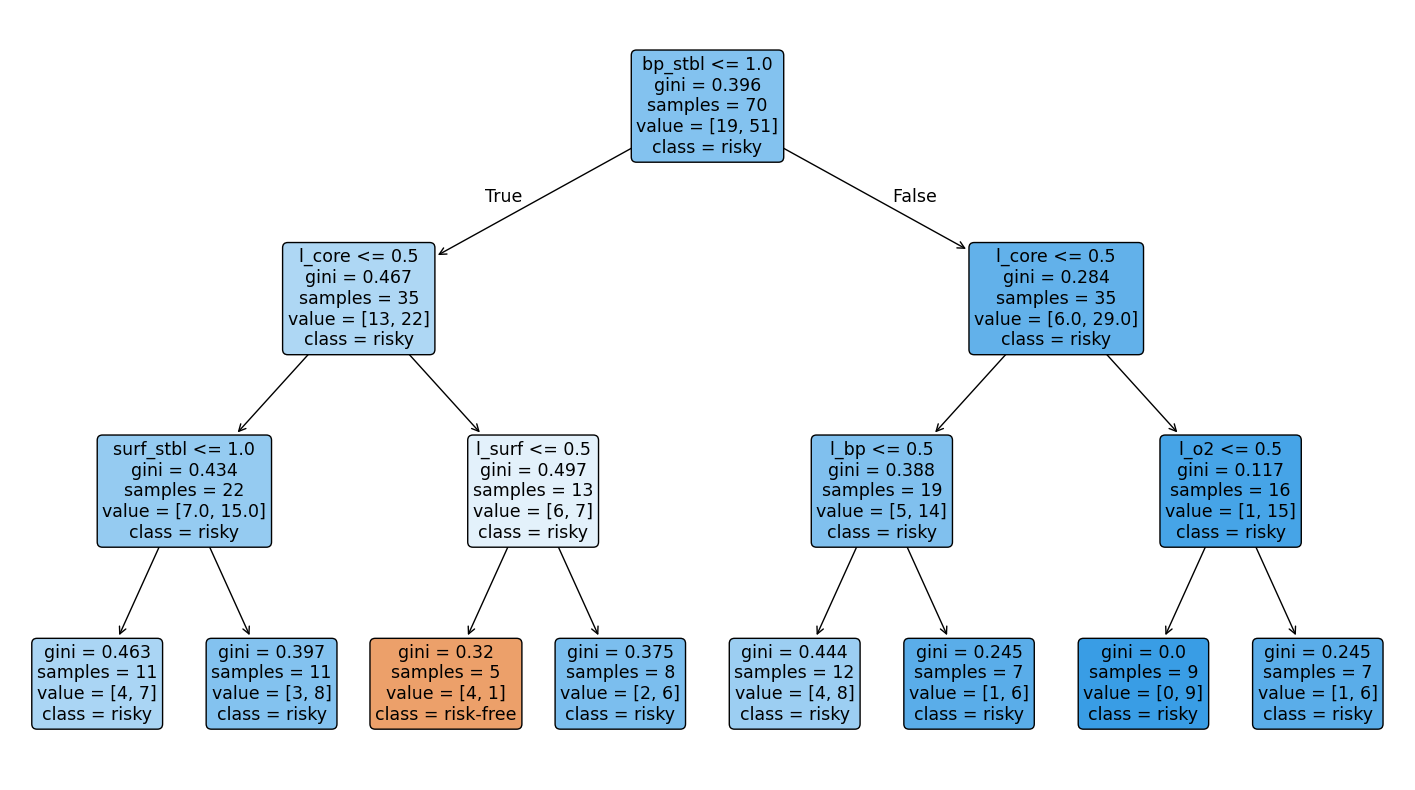

In [26]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(18,10))
plot_tree(
    dt,
    feature_names=X.columns,
    class_names=["risk-free", "risky"],
    filled=True,
    rounded=True
)
plt.show()


In [27]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    max_depth=3,
    min_samples_leaf=5,
    random_state=42,
    class_weight="balanced"  
)
dt.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",3
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current no

In [28]:
from sklearn.metrics import classification_report
import pandas as pd 

y_pred = dt.predict(X_test)

print(classification_report(y_test, y_pred))

importance = pd.Series(dt.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature importance:\n", importance)

              precision    recall  f1-score   support

           0       0.20      0.60      0.30         5
           1       0.33      0.08      0.12        13

    accuracy                           0.22        18
   macro avg       0.27      0.34      0.21        18
weighted avg       0.30      0.22      0.17        18

Feature importance:
 bp_stbl      0.317245
l_core       0.287711
l_surf       0.217193
l_bp         0.160452
surf_stbl    0.017400
l_o2         0.000000
core_stbl    0.000000
comfort      0.000000
dtype: float64


5-fold recall scores: [0.46153846 0.30769231 0.53846154 0.61538462 0.33333333]
Average recall: 0.4512820512820513

Classification Report (Test Set):

              precision    recall  f1-score   support

           0       0.21      0.60      0.32         5
           1       0.50      0.15      0.24        13

    accuracy                           0.28        18
   macro avg       0.36      0.38      0.28        18
weighted avg       0.42      0.28      0.26        18


Feature Importance:
 core_stbl    0.245160
bp_stbl      0.239216
l_bp         0.177468
surf_stbl    0.152045
l_core       0.126233
l_o2         0.059878
l_surf       0.000000
comfort      0.000000
dtype: float64


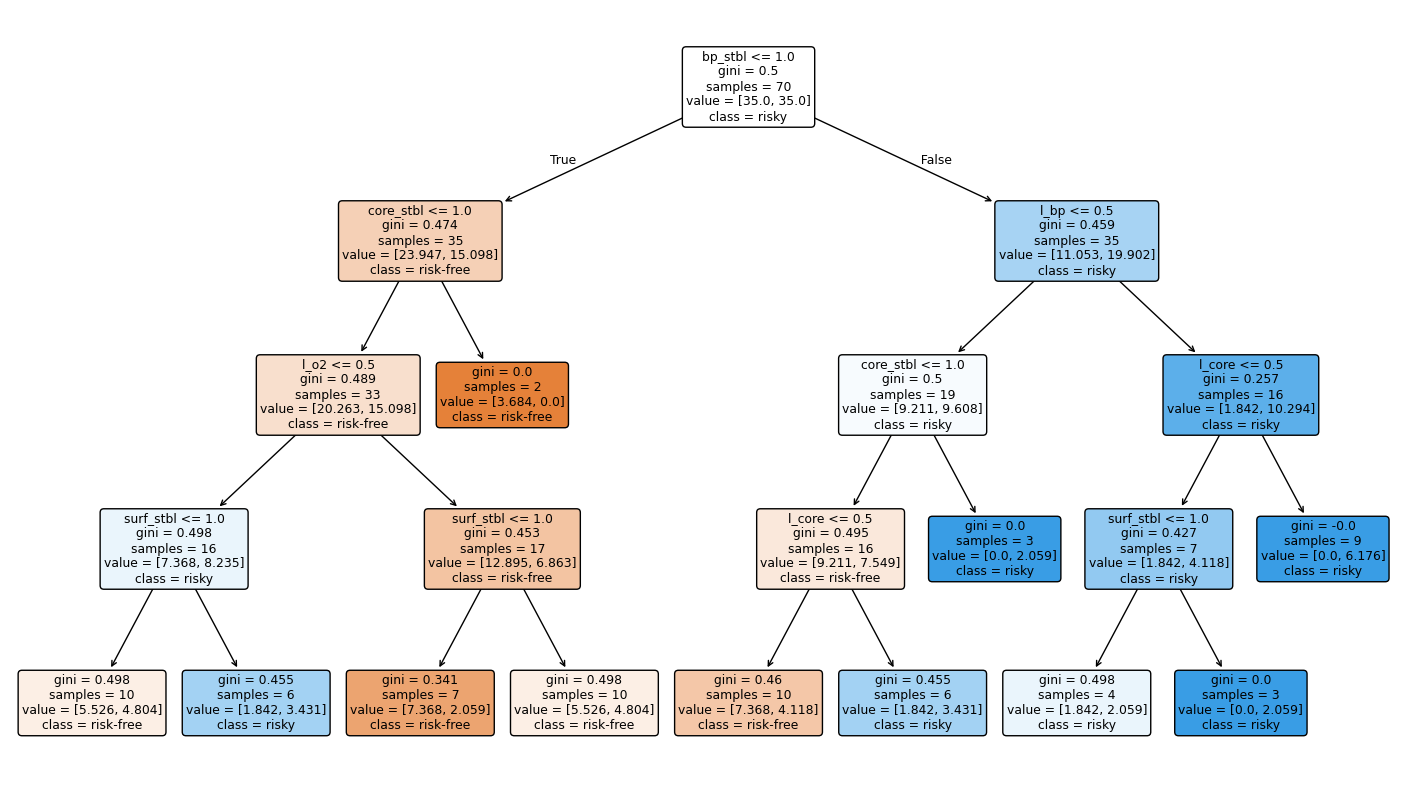

In [29]:
# -------------------------------
# Optimized Decision Tree for Postoperative Risk
# -------------------------------

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1️⃣ Veri yükleme ve temizleme
df = pd.read_csv("../data/post-operative-data.csv")

# Target sütun adını düzelt
df['decision ADM-DECS'] = df['decision ADM-DECS'].str.strip()
df = df[df['decision ADM-DECS'].isin(['A', 'S'])]
df = df.rename(columns={"decision ADM-DECS": "decision"})

# Sütun isimlerini küçük harf ve alt çizgi ile
df.columns = df.columns.str.lower().str.replace("-", "_").str.strip()

# comfort numeric ve NaN doldur
df['comfort'] = df['comfort'].replace('?', np.nan).astype(float)
df['comfort'] = df['comfort'].fillna(df['comfort'].median())

# Target encoding
df['decision'] = df['decision'].map({'S':0,'A':1})

# Feature encoding (klinik mantık)
level_map = {"mid": 0, "low": 1, "high": 1}
for col in ["l_core", "l_surf", "l_bp"]:
    df[col] = df[col].map(level_map)

o2_map = {"excellent":0,"good":1}
df["l_o2"] = df["l_o2"].map(o2_map)

stability_map = {"stable":0,"mod_stable":1,"unstable":2}
for col in ["core_stbl","surf_stbl","bp_stbl"]:
    df[col] = df[col].map(stability_map)

# 2️⃣ Feature ve target
X = df.drop("decision", axis=1)
y = df["decision"]

# 3️⃣ Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 4️⃣ Optimized Decision Tree
dt = DecisionTreeClassifier(
    max_depth=4,           # biraz daha derin → küçük risk branch'leri yakalansın
    min_samples_leaf=2,    # yapraklarda en az 2 örnek → riskli branch oluşsun
    class_weight="balanced", # sınıf dengesini azalt
    random_state=42
)
dt.fit(X_train, y_train)

# 5️⃣ Cross-validation ile recall kontrolü
cv_scores = cross_val_score(dt, X, y, cv=5, scoring="recall")
print("5-fold recall scores:", cv_scores)
print("Average recall:", cv_scores.mean())

# 6️⃣ Test set performansı
y_pred = dt.predict(X_test)
print("\nClassification Report (Test Set):\n")
print(classification_report(y_test, y_pred))

# 7️⃣ Feature importance
importance = pd.Series(dt.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nFeature Importance:\n", importance)

# 8️⃣ Decision Tree görselleştirme
plt.figure(figsize=(18,10))
plot_tree(
    dt,
    feature_names=X.columns,
    class_names=["risk-free","risky"],
    filled=True,
    rounded=True
)
plt.show()


5-fold recall scores: [0.84615385 1.         1.         0.84615385 0.91666667]
Average recall: 0.9217948717948719

Classification Report (Test Set):

              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.76      1.00      0.87        13

    accuracy                           0.78        18
   macro avg       0.88      0.60      0.60        18
weighted avg       0.83      0.78      0.72        18


Feature Importance:
 comfort      0.395380
core_stbl    0.307279
bp_stbl      0.198280
l_bp         0.099060
l_core       0.000000
l_surf       0.000000
l_o2         0.000000
surf_stbl    0.000000
dtype: float64


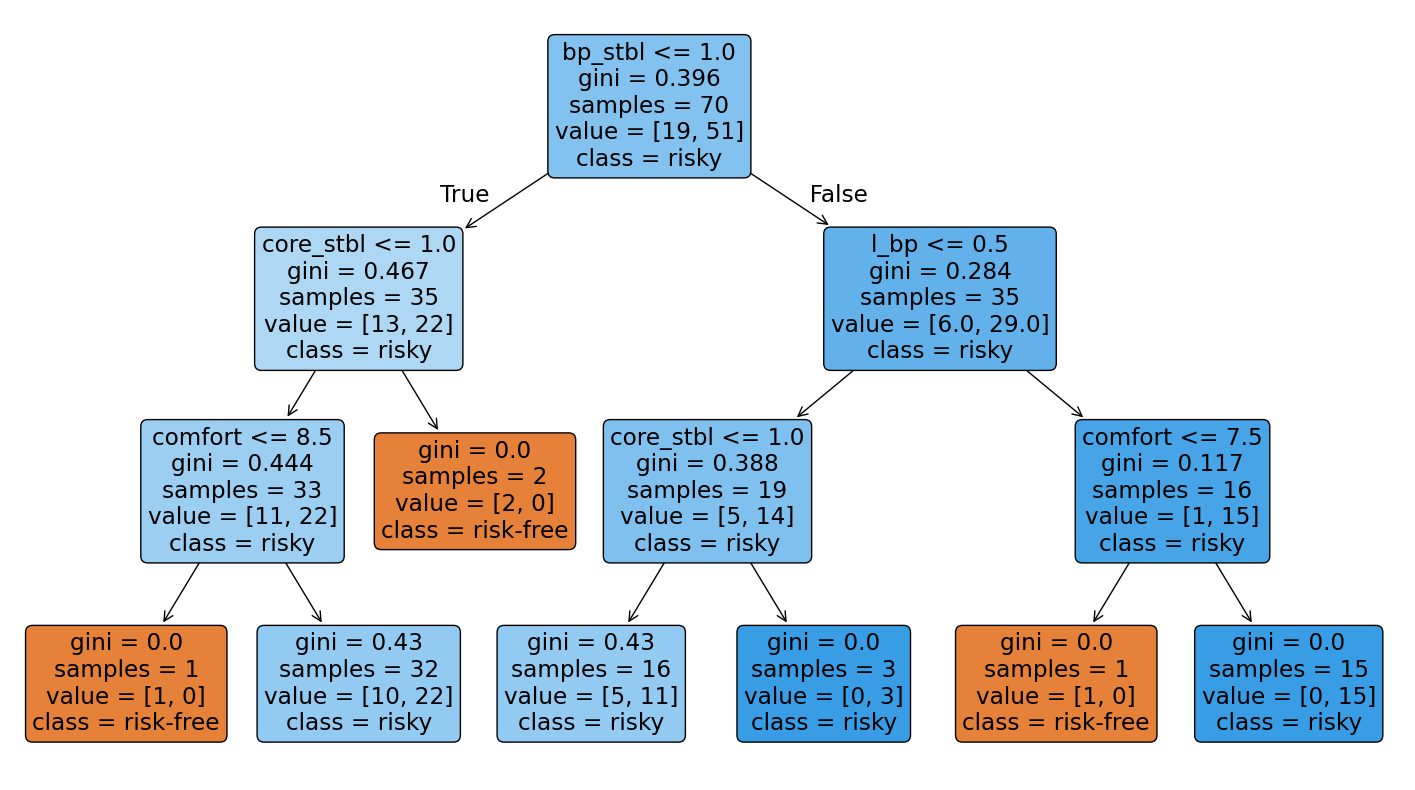

In [30]:
# -------------------------------
# Baseline Decision Tree (Small Dataset Safe)
# -------------------------------

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1️⃣ Veri yükleme ve temizleme
df = pd.read_csv("../data/post-operative-data.csv")

# Target sütun adını düzelt
df['decision ADM-DECS'] = df['decision ADM-DECS'].str.strip()
df = df[df['decision ADM-DECS'].isin(['A', 'S'])]
df = df.rename(columns={"decision ADM-DECS": "decision"})

# Sütun isimlerini küçük harf ve alt çizgi ile
df.columns = df.columns.str.lower().str.replace("-", "_").str.strip()

# comfort numeric ve NaN doldur
df['comfort'] = df['comfort'].replace('?', np.nan).astype(float)
df['comfort'] = df['comfort'].fillna(df['comfort'].median())

# Target encoding
df['decision'] = df['decision'].map({'S':0,'A':1})

# Feature encoding (klinik mantık)
level_map = {"mid": 0, "low": 1, "high": 1}
for col in ["l_core", "l_surf", "l_bp"]:
    df[col] = df[col].map(level_map)

o2_map = {"excellent":0,"good":1}
df["l_o2"] = df["l_o2"].map(o2_map)

stability_map = {"stable":0,"mod_stable":1,"unstable":2}
for col in ["core_stbl","surf_stbl","bp_stbl"]:
    df[col] = df[col].map(stability_map)

# 2️⃣ Feature ve target
X = df.drop("decision", axis=1)
y = df["decision"]

# 3️⃣ Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 4️⃣ Baseline Decision Tree
dt = DecisionTreeClassifier(
    max_depth=3,           # sığ ağaç → ezber önlenir, küçük risk branch’leri oluşur
    min_samples_leaf=1,    # küçük leaf → riskli branch oluşsun
    class_weight=None,     # küçük veri → riskli recall yüksek olsun
    random_state=42
)
dt.fit(X_train, y_train)

# 5️⃣ Cross-validation ile recall kontrolü
cv_scores = cross_val_score(dt, X, y, cv=5, scoring="recall")
print("5-fold recall scores:", cv_scores)
print("Average recall:", cv_scores.mean())

# 6️⃣ Test set performansı
y_pred = dt.predict(X_test)
print("\nClassification Report (Test Set):\n")
print(classification_report(y_test, y_pred))

# 7️⃣ Feature importance
importance = pd.Series(dt.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nFeature Importance:\n", importance)

# 8️⃣ Decision Tree görselleştirme
plt.figure(figsize=(18,10))
plot_tree(
    dt,
    feature_names=X.columns,
    class_names=["risk-free","risky"],
    filled=True,
    rounded=True
)
plt.show()


5-fold recall scores: [0.92307692 0.69230769 1.         0.84615385 0.66666667]
Average recall: 0.8256410256410257

Classification Report (Test Set):

              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.76      1.00      0.87        13

    accuracy                           0.78        18
   macro avg       0.88      0.60      0.60        18
weighted avg       0.83      0.78      0.72        18


Feature Importance:
 core_stbl    0.446318
bp_stbl      0.287999
l_core       0.143883
l_o2         0.121800
l_surf       0.000000
l_bp         0.000000
surf_stbl    0.000000
dtype: float64


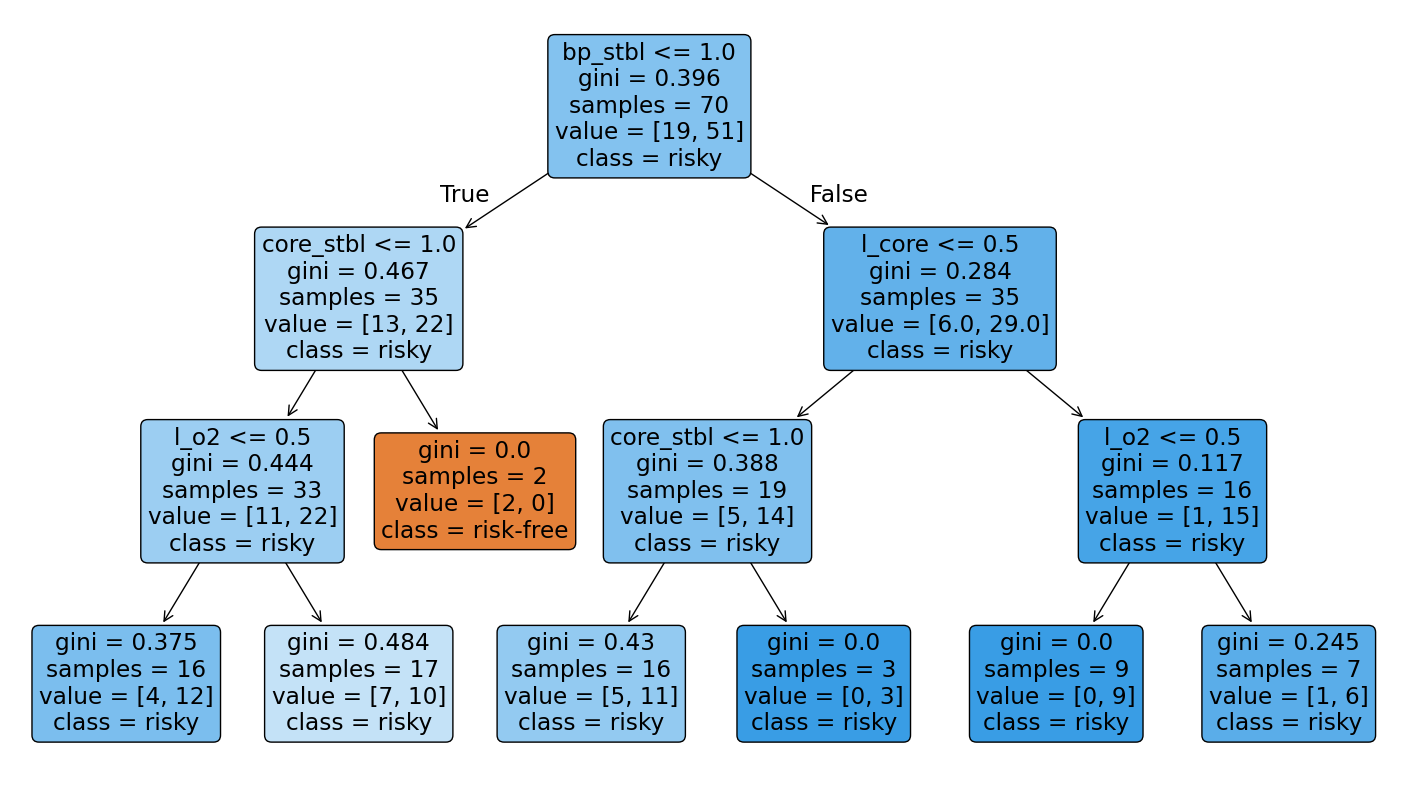

In [31]:
# -------------------------------
# Decision Tree - Comfort Kaldırılmış
# -------------------------------

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1️⃣ Veri yükleme ve temizleme
df = pd.read_csv("../data/post-operative-data.csv")

# Target sütun adını düzelt
df['decision ADM-DECS'] = df['decision ADM-DECS'].str.strip()
df = df[df['decision ADM-DECS'].isin(['A', 'S'])]
df = df.rename(columns={"decision ADM-DECS": "decision"})

# Sütun isimlerini küçük harf ve alt çizgi ile
df.columns = df.columns.str.lower().str.replace("-", "_").str.strip()

# comfort numeric ve NaN doldur
df['comfort'] = df['comfort'].replace('?', np.nan).astype(float)
df['comfort'] = df['comfort'].fillna(df['comfort'].median())

# Target encoding
df['decision'] = df['decision'].map({'S':0,'A':1})

# Feature encoding (klinik mantık)
level_map = {"mid": 0, "low": 1, "high": 1}
for col in ["l_core", "l_surf", "l_bp"]:
    df[col] = df[col].map(level_map)

o2_map = {"excellent":0,"good":1}
df["l_o2"] = df["l_o2"].map(o2_map)

stability_map = {"stable":0,"mod_stable":1,"unstable":2}
for col in ["core_stbl","surf_stbl","bp_stbl"]:
    df[col] = df[col].map(stability_map)

# 2️⃣ Feature ve target (comfort çıkarıldı)
X = df.drop(["decision","comfort"], axis=1)
y = df["decision"]

# 3️⃣ Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 4️⃣ Decision Tree
dt = DecisionTreeClassifier(
    max_depth=3,
    min_samples_leaf=1,
    class_weight=None,
    random_state=42
)
dt.fit(X_train, y_train)

# 5️⃣ Cross-validation ile recall kontrolü
cv_scores = cross_val_score(dt, X, y, cv=5, scoring="recall")
print("5-fold recall scores:", cv_scores)
print("Average recall:", cv_scores.mean())

# 6️⃣ Test set performansı
y_pred = dt.predict(X_test)
print("\nClassification Report (Test Set):\n")
print(classification_report(y_test, y_pred))

# 7️⃣ Feature importance
importance = pd.Series(dt.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nFeature Importance:\n", importance)

# 8️⃣ Decision Tree görselleştirme
plt.figure(figsize=(18,10))
plot_tree(
    dt,
    feature_names=X.columns,
    class_names=["risk-free","risky"],
    filled=True,
    rounded=True
)
plt.show()


In [32]:
# -------------------------------
# SMOTE + Decision Tree / Random Forest
# -------------------------------

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# 1️⃣ Veri yükleme ve temizleme
df = pd.read_csv("../data/post-operative-data.csv")

df['decision ADM-DECS'] = df['decision ADM-DECS'].str.strip()
df = df[df['decision ADM-DECS'].isin(['A','S'])]
df = df.rename(columns={"decision ADM-DECS":"decision"})

df.columns = df.columns.str.lower().str.replace("-", "_").str.strip()

df['comfort'] = df['comfort'].replace('?', np.nan).astype(float)
df['comfort'] = df['comfort'].fillna(df['comfort'].median())

df['decision'] = df['decision'].map({'S':0,'A':1})

# Feature encoding (klinik mantık)
level_map = {"mid":0,"low":1,"high":1}
for col in ["l_core","l_surf","l_bp"]:
    df[col] = df[col].map(level_map)

o2_map = {"excellent":0,"good":1}
df["l_o2"] = df["l_o2"].map(o2_map)

stability_map = {"stable":0,"mod_stable":1,"unstable":2}
for col in ["core_stbl","surf_stbl","bp_stbl"]:
    df[col] = df[col].map(stability_map)

# Features & target (comfort çıkarıldı)
X = df.drop(["decision","comfort"], axis=1)
y = df["decision"]

# 2️⃣ Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.2,random_state=42,stratify=y
)

# 3️⃣ SMOTE ile train seti dengele
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Original train class counts:\n", y_train.value_counts())
print("Resampled train class counts:\n", y_train_res.value_counts())

# 4️⃣ Decision Tree
dt = DecisionTreeClassifier(max_depth=3,min_samples_leaf=1,random_state=42)
dt.fit(X_train_res, y_train_res)

y_pred_dt = dt.predict(X_test)
print("\nDecision Tree Classification Report:\n")
print(classification_report(y_test, y_pred_dt))

# Feature importance
importance_dt = pd.Series(dt.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nDecision Tree Feature Importance:\n", importance_dt)

# Tree görselleştirme
plt.figure(figsize=(18,10))
plot_tree(dt,feature_names=X.columns,class_names=["risk-free","risky"],filled=True,rounded=True)
plt.show()

# 5️⃣ Random Forest
rf = RandomForestClassifier(n_estimators=100,max_depth=3,min_samples_leaf=1,random_state=42)
rf.fit(X_train_res, y_train_res)

y_pred_rf = rf.predict(X_test)
print("\nRandom Forest Classification Report:\n")
print(classification_report(y_test, y_pred_rf))

importance_rf = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nRandom Forest Feature Importance:\n", importance_rf)


ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [33]:
X_train.isna().sum()


l_core        0
l_surf        0
l_o2          0
l_bp          0
surf_stbl     0
core_stbl     1
bp_stbl      18
dtype: int64

In [ ]:
X_test.isna().sum()


l_core       0
l_surf       0
l_o2         0
l_bp         0
surf_stbl    0
core_stbl    0
bp_stbl      3
dtype: int64

In [34]:
df['bp_stbl'].value_counts(dropna=False)


bp_stbl
0.0    45
2.0    22
NaN    21
Name: count, dtype: int64

In [35]:
df['bp_stbl'].unique()


array([ 0., nan,  2.])

In [36]:
for col in ['l_core', 'l_surf', 'l_o2', 'l_bp', 'surf_stbl', 'core_stbl', 'bp_stbl']:
    df[col] = df[col].astype(str).str.strip().str.lower()
